In [1]:
# DATE: 17th december 2024

import os
import cv2
import easyocr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import joblib
import tensorflow as tf
import re



In [2]:
# Text Extraction from Images
def extract_text_from_image(image_path, reader):
    image = cv2.imread(image_path)
    results = reader.readtext(image)
    extracted_text = ' '.join([text for (_, text, _) in results])
    return extracted_text

# Image Feature Extraction using Pre-trained CNN
def extract_image_features(image_path, cnn_model, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
    image = image / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)
    features = cnn_model.predict(image)
    return features.flatten()

# Dataset Preparation
def prepare_dataset(dataset_path, cnn_model, reader, img_size=(224, 224)):
    categories = os.listdir(dataset_path)
    data = {'text': [], 'image_features': [], 'category': []}
    
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.isdir(category_path):
            continue
        print(f"Processing category: {category}")
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                text = extract_text_from_image(img_path, reader)
                img_features = extract_image_features(img_path, cnn_model, img_size)
                data['text'].append(text)
                data['image_features'].append(img_features)
                data['category'].append(category)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    df = pd.DataFrame(data)
    return df

# Text Preprocessing
def preprocess_text(df):
    df['clean_text'] = df['text'].str.lower().str.replace('[^a-z0-9\s]', ' ', regex=True)
    df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in ENGLISH_STOP_WORDS]))
    return df

# Train Hybrid Model
def train_hybrid_model(df):
    # Label Encoding
    label_encoder = LabelEncoder()
    df['category_encoded'] = label_encoder.fit_transform(df['category'])
    
    # Text Features
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    text_features = vectorizer.fit_transform(df['clean_text'])
    
    # Combine Features
    image_features = np.array(df['image_features'].tolist())
    combined_features = np.hstack((text_features.toarray(), image_features))
    
    # Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(
        combined_features, df['category_encoded'], test_size=0.2, random_state=42, stratify=df['category_encoded']
    )
    
    # Train Classifier
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(X_train, y_train)
    
    # Evaluate Model
    y_pred = classifier.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    
    return vectorizer, classifier, label_encoder

# Save Models
def save_hybrid_model(vectorizer, classifier, label_encoder, vectorizer_path='vectorizer.joblib', classifier_path='classifier.joblib', label_encoder_path='label_encoder.joblib'):
    joblib.dump(vectorizer, vectorizer_path)
    joblib.dump(classifier, classifier_path)
    joblib.dump(label_encoder, label_encoder_path)
    print(f"Models saved.")

# Prediction
def predict_category(image_path, reader, cnn_model, vectorizer, classifier, label_encoder):
    text = extract_text_from_image(image_path, reader)
    clean_text = text.lower()
    clean_text = re.sub('[^a-z0-9\s]', ' ', clean_text)
    text_features = vectorizer.transform([clean_text])
    
    img_features = extract_image_features(image_path, cnn_model)
    combined_features = np.hstack((text_features.toarray(), img_features.reshape(1, -1)))
    
    prediction = classifier.predict(combined_features)[0]
    predicted_category = label_encoder.inverse_transform([prediction])[0]
    return predicted_category, text

In [3]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS



# Main Script
dataset_path = 'C:/ML_CEP/classification_model_3/train/'  # Replace with your dataset path
reader = easyocr.Reader(['en'])

# Load Pre-trained CNN
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
cnn_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Prepare Dataset
df = prepare_dataset(dataset_path, cnn_model, reader)
print(f"Total samples: {len(df)}")

# Preprocess Text
df = preprocess_text(df)

# Train Hybrid Model
vectorizer, classifier, label_encoder = train_hybrid_model(df)

# Save Models
save_hybrid_model(vectorizer, classifier, label_encoder)




Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Processing category: Beverages
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

Predicted Category: Books
Detected Text: IT ENDSL WITH US COLLEEN HOQVER


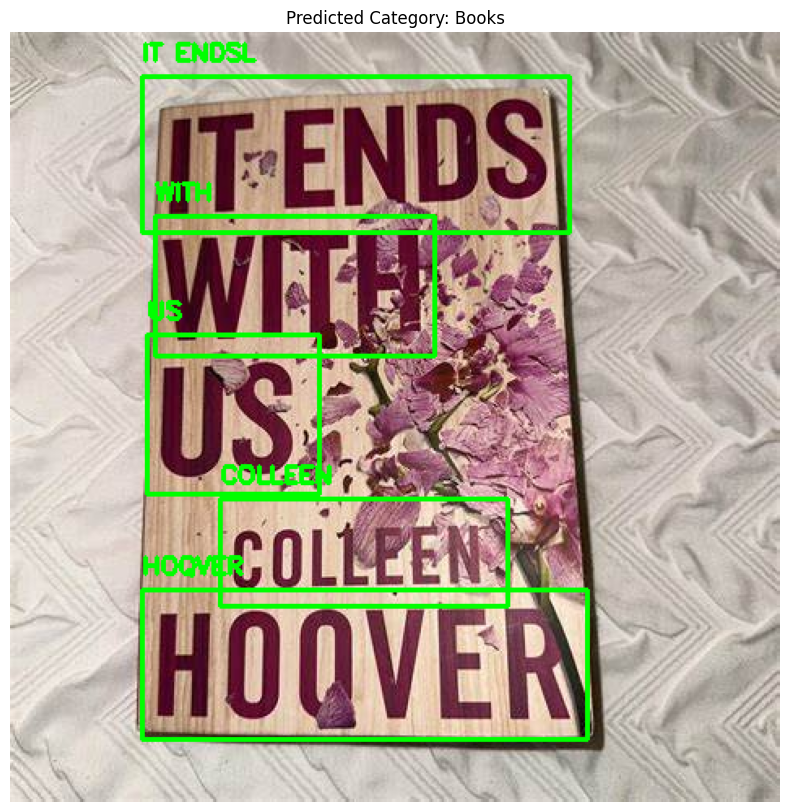

In [17]:
# Predict Example
test_image = 'C:/ML_CEP/classification_model_3/val/14.jpg'  # Replace with your test image path
predicted_category, detected_text = predict_category(test_image, reader, cnn_model, vectorizer, classifier, label_encoder)
print(f"\nPredicted Category: {predicted_category}")
print(f"Detected Text: {detected_text}")

# Display Image with Predictions
image = cv2.imread(test_image)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = reader.readtext(image)
for (bbox, text, prob) in results:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    cv2.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)
    cv2.putText(image_rgb, text, (top_left[0], top_left[1] - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.title(f"Predicted Category: {predicted_category}")
plt.show()